<a href="https://colab.research.google.com/github/nick-monto/disentangled_directions/blob/master/disentangled_directions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
# for input generation
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.random import randint, choice, dirichlet
from pandas import get_dummies
from PIL import Image, ImageDraw

# for input analysis
import pandas as pd

# for model
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.compat.v1 import set_random_seed
from tensorflow.compat.v1.keras.utils import to_categorical
from tensorflow.compat.v1.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import BatchNormalization, Conv3D, Dense, \
                                              Dropout, Flatten, Input, ReLU, Softmax

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
def findMiddleIndex(input_list):
    middle = float(len(input_list))/2
    if middle % 2 != 0:
        return [int(middle - .5)]
    else:
        return (int(middle), int(middle-1))

In [0]:
def centralSort(flat_array):
  descSort = -np.sort(-flat_array)[0]
  cen_sorted = []
  for i in reversed(range(len(descSort))):
    while i >= len(descSort) - 2:
      cen_sorted.append(descSort[i])
      i -= 1
    while i == len(descSort) - 3:
      cen_sorted.insert(1,descSort[i])
      i -= 1
    helpme = findMiddleIndex(cen_sorted)
    if len(helpme) >= 2:
      cen_sorted.insert(helpme[1], descSort[i])
    else:
      cen_sorted.insert(helpme[0], descSort[i])
  uniques = [ii for n,ii in enumerate(cen_sorted) if ii not in cen_sorted[:n]]
  return uniques    

In [0]:
# big ugly function to generate stimuli
def central_image(dims, text, movement, show = False, to_matrix = True):
  x = randint(30,91)
  y = randint(30,91)
  base_coords = np.asarray((x, y))
  img = Image.new('L', dims)
  d = ImageDraw.Draw(img)
  d.text((x, y), text, fill=(255))
  if movement == 'R':
    # generate probability list for weighted movement
    prob_list = dirichlet(range(1,21), 1) # first arguement must be >0
    # descending sort
    probs = centralSort(prob_list)
    # random choice from uniform distribution of range 5-24
    x += choice(np.arange(5,25), 1, p=probs)
    prob_list = dirichlet(range(1,21), 1) # first arguement must be >0
    # descending sort
    probs = -np.sort(-prob_list)[0]
    flip = randint(0,2)
    if flip == 0:
      y += choice(np.arange(0,20), 1, p=probs)
    else:
      y -= choice(np.arange(0,20), 1, p=probs)
    img1 = Image.new('L', dims)
    d = ImageDraw.Draw(img1)
    d.text((x,y), text, fill=(255))
  elif movement == 'L':
    # generate probability list for weighted movement
    prob_list = dirichlet(range(1,21), 1)
    probs = centralSort(prob_list)
    x -= choice(np.arange(5,25), 1, p=probs)
    prob_list = dirichlet(range(1,21), 1) # first arguement must be >0
    # descending sort
    probs = -np.sort(-prob_list)[0]
    flip = randint(0,2)
    if flip == 0:
      y += choice(np.arange(0,20), 1, p=probs)
    else:
      y -= choice(np.arange(0,20), 1, p=probs)
    img1 = Image.new('L', dims)
    d = ImageDraw.Draw(img1)
    d.text((x,y), text, fill=(255))
  elif movement == 'U':
    # generate probability list for weighted movement
    prob_list = dirichlet(range(1,21), 1)
    probs = centralSort(prob_list)
    y -= choice(np.arange(5,25), 1, p=probs)
    # generate probability list for weighted movement
    prob_list = dirichlet(range(1,21), 1)
    probs = -np.sort(-prob_list)[0]
    flip = randint(0,2)
    if flip == 0:
      x += choice(np.arange(0,20), 1, p=probs)
    else:
      x -= choice(np.arange(0,20), 1, p=probs)
    img1 = Image.new('L', dims)
    d = ImageDraw.Draw(img1)
    d.text((x,y), text, fill=(255))
  elif movement == 'D':
    # generate probability list for weighted movement
    prob_list = dirichlet(range(1,21), 1)
    probs = centralSort(prob_list)
    y += choice(np.arange(5,25), 1, p=probs)
    prob_list = dirichlet(range(1,21), 1) # first arguement must be >0
    # descending sort
    probs = -np.sort(-prob_list)[0]
    flip = randint(0,2)
    if flip == 0:
      x += choice(np.arange(0,20), 1, p=probs)
    else:
      x -= choice(np.arange(0,20), 1, p=probs)
    img1 = Image.new('L', dims)
    d = ImageDraw.Draw(img1)
    d.text((x,y), text, fill=(255))
  else:
    print("Please use U, D, L, or R to indicate movement direction.")
  if show == True:
    fig = plt.figure()
    a=fig.add_subplot(1,2,1)
    a.set_title('Before')
    plt.imshow(np.asarray(img))
    a=fig.add_subplot(1,2,2)
    a.set_title('After '+ movement + ' shift')
    plt.imshow(np.asarray(img1))
  if to_matrix == True:
    stimulus, label = np.array([np.asarray(img), np.asarray(img1)]), movement
    shift_coords = np.asarray((x[0],y[0]))
    change = shift_coords - base_coords
    return stimulus, label, change

In [0]:
# set up the probability space to be "trivial"
# big ugly function to generate stimuli
def trivial_image(dims, text, movement, show = False, to_matrix = True):
  x = randint(30,91)
  y = randint(30,91)
  base_coords = np.asarray((x, y))
  img = Image.new('L', dims)
  d = ImageDraw.Draw(img)
  d.text((x, y), text, fill=(255))
  if movement == 'R':
    # generate probability list for weighted movement
    prob_list = dirichlet(range(1,21), 1) # first arguement must be >0
    # ascending sort
    probs = np.sort(prob_list)[0]
    # random choice from uniform distribution of range 5-24
    x += choice(np.arange(5,25), 1, p=probs)
    prob_list = dirichlet(range(1,21), 1) # first arguement must be >0
    # descending sort
    probs = -np.sort(-prob_list)[0]
    flip = randint(0,2)
    if flip == 0:
      y += choice(np.arange(0,20), 1, p=probs)
    else:
      y -= choice(np.arange(0,20), 1, p=probs)
    img1 = Image.new('L', dims)
    d = ImageDraw.Draw(img1)
    d.text((x,y), text, fill=(255))
  elif movement == 'L':
    # generate probability list for weighted movement
    prob_list = dirichlet(range(1,21), 1)
    probs = np.sort(prob_list)[0]
    x -= choice(np.arange(5,25), 1, p=probs)
    prob_list = dirichlet(range(1,21), 1) # first arguement must be >0
    # descending sort
    probs = -np.sort(-prob_list)[0]
    flip = randint(0,2)
    if flip == 0:
      y += choice(np.arange(0,20), 1, p=probs)
    else:
      y -= choice(np.arange(0,20), 1, p=probs)
    img1 = Image.new('L', dims)
    d = ImageDraw.Draw(img1)
    d.text((x,y), text, fill=(255))
  elif movement == 'U':
    # generate probability list for weighted movement
    prob_list = dirichlet(range(1,21), 1)
    probs = np.sort(prob_list)[0]
    y -= choice(np.arange(5,25), 1, p=probs)
    # generate probability list for weighted movement
    prob_list = dirichlet(range(1,21), 1)
    probs = -np.sort(-prob_list)[0]
    flip = randint(0,2)
    if flip == 0:
      x += choice(np.arange(0,20), 1, p=probs)
    else:
      x -= choice(np.arange(0,20), 1, p=probs)
    img1 = Image.new('L', dims)
    d = ImageDraw.Draw(img1)
    d.text((x,y), text, fill=(255))
  elif movement == 'D':
    # generate probability list for weighted movement
    prob_list = dirichlet(range(1,21), 1)
    probs = np.sort(prob_list)[0]
    y += choice(np.arange(5,25), 1, p=probs)
    prob_list = dirichlet(range(1,21), 1) # first arguement must be >0
    # descending sort
    probs = -np.sort(-prob_list)[0]
    flip = randint(0,2)
    if flip == 0:
      x += choice(np.arange(0,20), 1, p=probs)
    else:
      x -= choice(np.arange(0,20), 1, p=probs)
    img1 = Image.new('L', dims)
    d = ImageDraw.Draw(img1)
    d.text((x,y), text, fill=(255))
  else:
    print("Please use U, D, L, or R to indicate movement direction.")
  if show == True:
    fig = plt.figure()
    a=fig.add_subplot(1,2,1)
    a.set_title('Before')
    plt.imshow(np.asarray(img))
    a=fig.add_subplot(1,2,2)
    a.set_title('After '+ movement + ' shift')
    plt.imshow(np.asarray(img1))
  if to_matrix == True:
    stimulus, label = np.array([np.asarray(img), np.asarray(img1)]), movement
    shift_coords = np.asarray((x[0],y[0]))
    change = shift_coords - base_coords
    return stimulus, label, change

In [0]:
# set up the probability space to overlap completely
# big ugly function to generate stimuli
def overlap_image(dims, text, movement, show = False, to_matrix = True):
  x = randint(30,91)
  y = randint(30,91)
  base_coords = np.asarray((x, y))
  img = Image.new('L', dims)
  d = ImageDraw.Draw(img)
  d.text((x, y), text, fill=(255))
  if movement == 'R':
    # generate probability list for weighted movement
    prob_list = dirichlet(range(1,21), 1) # first arguement must be >0
    # descending sort
    probs = -np.sort(-prob_list)[0]
    # random choice from uniform distribution of range 5-24
    x += choice(np.arange(5,25), 1, p=probs)
    prob_list = dirichlet(range(1,21), 1) # first arguement must be >0
    # descending sort
    probs = -np.sort(-prob_list)[0]
    flip = randint(0,2)
    if flip == 0:
      y += choice(np.arange(0,20), 1, p=probs)
    else:
      y -= choice(np.arange(0,20), 1, p=probs)
    img1 = Image.new('L', dims)
    d = ImageDraw.Draw(img1)
    d.text((x,y), text, fill=(255))
  elif movement == 'L':
    # generate probability list for weighted movement
    prob_list = dirichlet(range(1,21), 1)
    probs = -np.sort(-prob_list)[0]
    x -= choice(np.arange(5,25), 1, p=probs)
    prob_list = dirichlet(range(1,21), 1) # first arguement must be >0
    # descending sort
    probs = -np.sort(-prob_list)[0]
    flip = randint(0,2)
    if flip == 0:
      y += choice(np.arange(0,20), 1, p=probs)
    else:
      y -= choice(np.arange(0,20), 1, p=probs)
    img1 = Image.new('L', dims)
    d = ImageDraw.Draw(img1)
    d.text((x,y), text, fill=(255))
  elif movement == 'U':
    # generate probability list for weighted movement
    prob_list = dirichlet(range(1,21), 1)
    probs = -np.sort(-prob_list)[0]
    y -= choice(np.arange(5,25), 1, p=probs)
    # generate probability list for weighted movement
    prob_list = dirichlet(range(1,21), 1)
    probs = -np.sort(-prob_list)[0]
    flip = randint(0,2)
    if flip == 0:
      x += choice(np.arange(0,20), 1, p=probs)
    else:
      x -= choice(np.arange(0,20), 1, p=probs)
    img1 = Image.new('L', dims)
    d = ImageDraw.Draw(img1)
    d.text((x,y), text, fill=(255))
  elif movement == 'D':
    # generate probability list for weighted movement
    prob_list = dirichlet(range(1,21), 1)
    probs = -np.sort(-prob_list)[0]
    y += choice(np.arange(5,25), 1, p=probs)
    prob_list = dirichlet(range(1,21), 1) # first arguement must be >0
    # descending sort
    probs = -np.sort(-prob_list)[0]
    flip = randint(0,2)
    if flip == 0:
      x += choice(np.arange(0,20), 1, p=probs)
    else:
      x -= choice(np.arange(0,20), 1, p=probs)
    img1 = Image.new('L', dims)
    d = ImageDraw.Draw(img1)
    d.text((x,y), text, fill=(255))
  else:
    print("Please use U, D, L, or R to indicate movement direction.")
  if show == True:
    fig = plt.figure()
    a=fig.add_subplot(1,2,1)
    a.set_title('Before')
    plt.imshow(np.asarray(img))
    a=fig.add_subplot(1,2,2)
    a.set_title('After '+ movement + ' shift')
    plt.imshow(np.asarray(img1))
  if to_matrix == True:
    stimulus, label = np.array([np.asarray(img), np.asarray(img1)]), movement
    shift_coords = np.asarray((x[0],y[0]))
    change = shift_coords - base_coords
    return stimulus, label, change

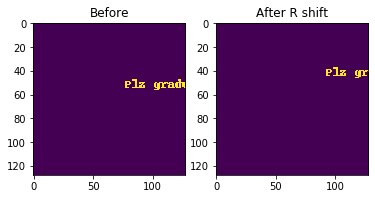

In [0]:
# in order to show the images, all you have to do is indicate show=True

# base function
test = central_image((128,128), 'Plz graduate', 'R', show=True)

In [0]:
test

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8), 'R', array([ 15, -10]))

In [0]:
# can look at shape of input stimulus as so
print(test[0].shape)

# each layer like so
print(test[0][0])
test[0][1]

# and its associated label like this
print(test[1])

(2, 128, 128)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
R


array([23, 14])

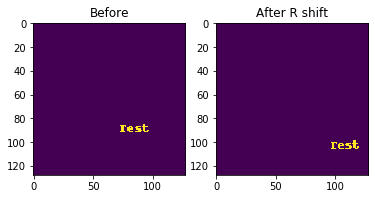

In [0]:
# example of another direction
test = central_image((128,128), 'Test', 'R', show=True)
test[2]

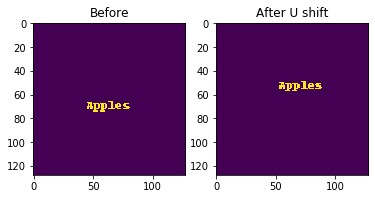

In [0]:
# set to_matrix as False and show to True if you're just playing around
central_image((128,128), 'Apples', 'U', show=True, to_matrix=False)

In [0]:
# generate 300 stimulus pairs for the central shifts
directions = ['U','D','L','R']
central_list = []

for i in range(300):
  central_list.append(central_image((128,128), 'Orange', choice(directions)))
  
# lets add some more variety to the written cases
# add more variation if you want
text_values = ['king','queen','list','hedge','dog','cat','truck','horse',\
               'prince', 'cow', 'smile','laugh','frown','boat','car',\
              'vehicle','red','silver','glitch','matrix','keanu','fin']

# then generate an addition 300 cases for each item in the text list
for x in text_values:
  for i in range(300):
    central_list.append(central_image((128,128), x, choice(directions)))

In [0]:
# generate 300 stimulus pairs for the trivial shifts
directions = ['U','D','L','R']
trivial_list = []

for i in range(300):
  trivial_list.append(trivial_image((128,128), 'Orange', choice(directions)))
  
# lets add some more variety to the written cases
# add more variation if you want
text_values = ['king','queen','list','hedge','dog','cat','truck','horse',\
               'prince', 'cow', 'smile','laugh','frown','boat','car',\
              'vehicle','red','silver','glitch','matrix','keanu','fin']

# then generate an addition 300 cases for each item in the text list
for x in text_values:
  for i in range(300):
    trivial_list.append(trivial_image((128,128), x, choice(directions)))

In [0]:
# generate 300 stimulus pairs for the overlap pairs
overlap_list = []

for i in range(300):
  overlap_list.append(overlap_image((128,128), 'Orange', choice(directions)))
  
# lets add some more variety to the written cases
# add more variation if you want
text_values = ['king','queen','list','hedge','dog','cat','truck','horse',\
               'prince', 'cow', 'smile','laugh','frown','boat','car',\
              'vehicle','red','silver','glitch','matrix','keanu','fin']

# then generate an addition 300 cases for each item in the text list
for x in text_values:
  for i in range(300):
    overlap_list.append(overlap_image((128,128), x, choice(directions)))

In [0]:
def plot_dataHist(stimuli_array, plot_title, plot=True): 
  df = []
  for i in range(len(stimuli_array)):
    df.append((stimuli_array[i][2], stimuli_array[i][1]))
  df = pd.DataFrame(df, columns=["XY_change", "Label"])
  df['Difference'] = 0
  for i in range(len(df)):
    difference = abs(df["XY_change"][i][1]) - abs(df["XY_change"][i][0])
    df.at[i,'Difference'] = difference
  if plot:
    plt.style.use('seaborn-deep')

    R = df[df['Label'] == "R"]
    L = df[df['Label'] == "L"]
    U = df[df['Label'] == "U"]
    D = df[df['Label'] == "D"]
    bins = np.linspace(-25, 25, 30)

    plt.hist([R['Difference'], L['Difference'], U['Difference'], D['Difference']], bins, label=['R','L','U','D'])
    plt.title(plot_title)
    plt.legend(loc='upper right')
    plt.show()
  return df

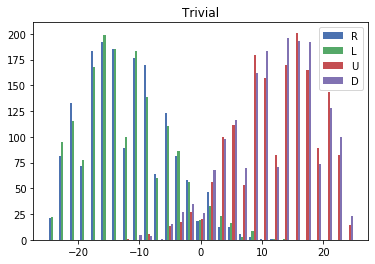

In [0]:
trivial_hist = plot_dataHist(trivial_list, "Trivial")

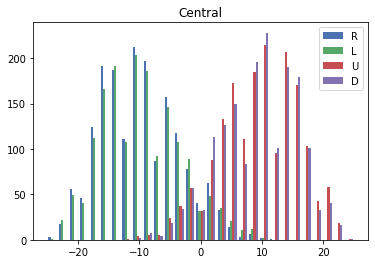

In [0]:
central_hist = plot_dataHist(central_list, "Central")

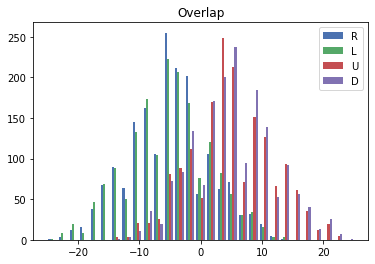

In [0]:
overlap_hist = plot_dataHist(overlap_list, "Overlap")

In [0]:
def stim_massage(stimulus_list):
  data = []
  labels = []
  data, labels, change = zip(*stimulus_list)

  # reshape image input to include an additional channel 
  # the -1 is a placeholder that will take the left over number 
  # number of images in this case
  data = np.reshape(np.asarray(data), (-1,2,128,128,1))
  print("The shape of the data is: {}.".format(data.shape))
  # one hot encode variables
  # because we are using categorical crossentropy for loss
  labels = get_dummies(labels).values
  print("The shape of the labels is: {}.".format(labels.shape))
  return data, labels

In [0]:
dat, lab = stim_massage(central_list)

The shape of the data is: (6900, 2, 128, 128, 1).
The shape of the labels is: (6900, 4).


In [0]:
# Old method of building models with Keras

# keras.io has documentation for all the available layers etc...

model.add(Input(batch_shape=(None,2,128,128,1), name="Input"))
model.add(Conv3D(8, (1,3,3), (1,2,2), padding='same',
                 activation='relu', name="Conv1"))
model.add(BatchNormalization(axis=-1))

model.add(Conv3D(16, (1,3,3), (1,2,2), padding='same',
                 activation='relu', name="Conv2"))
model.add(BatchNormalization(axis=-1))

model.add(Conv3D(32, (1,3,3), (1,2,2), padding='same',
                 activation='relu', name="Conv3"))
model.add(BatchNormalization(axis=-1))

model.add(Flatten())
model.add(Dense(256, activation='relu', name='fc1'))
model.add(Dropout(0.50, name='do1'))
model.add(Dense(128, activation='relu', name='fc2'))
model.add(Dense(len(lab[0]), activation='softmax', name="output"))

# compile the network with categorical cross entropy loss function
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# New method of building models with Keras
model = Sequential([
    Input(batch_shape=(None,2,128,128,1), name="Input"),

    Conv3D(8, (1,3,3), (1,2,2), padding='same', activation='relu', name="Conv1"),
    BatchNormalization(axis=-1),

    Conv3D(16, (1,3,3), (1,2,2), padding='same', activation='relu', name="Conv2"),
    BatchNormalization(axis=-1),

    Conv3D(32, (1,3,3), (1,2,2), padding='same', activation='relu', name="Conv3"),
    BatchNormalization(axis=-1),

    Flatten(),
    Dense(256, activation='relu', name='fc1'),
    Dropout(0.50, name='do1'),
    Dense(128, activation='relu', name='fc2'),
    Dense(len(lab[0]), activation='softmax', name="output")
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv3D)               (None, 2, 64, 64, 8)      80        
_________________________________________________________________
batch_normalization_3 (Batch (None, 2, 64, 64, 8)      32        
_________________________________________________________________
Conv2 (Conv3D)               (None, 2, 32, 32, 16)     1168      
_________________________________________________________________
batch_normalization_4 (Batch (None, 2, 32, 32, 16)     64        
_________________________________________________________________
Conv3 (Conv3D)               (None, 2, 16, 16, 32)     4640      
_________________________________________________________________
batch_normalization_5 (Batch (None, 2, 16, 16, 32)     128       
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

In [0]:
# train the model on an 80/20 split for a user decided number of epochs
# defaults to a 32 batch size
model.fit(dat.astype('float16'), lab,
          batch_size=32,
          validation_split=0.2, epochs=5,
          verbose=1)

Train on 5520 samples, validate on 1380 samples
Epoch 1/5
5520/5520 [==============================] - 49s 9ms/sample - loss: 1.0598 - acc: 0.6270 - val_loss: 0.5097 - val_acc: 0.8283
Epoch 2/5
5520/5520 [==============================] - 48s 9ms/sample - loss: 0.5236 - acc: 0.8178 - val_loss: 0.4587 - val_acc: 0.8399
Epoch 3/5
5520/5520 [==============================] - 48s 9ms/sample - loss: 0.3428 - acc: 0.8793 - val_loss: 0.4387 - val_acc: 0.8580
Epoch 4/5
5520/5520 [==============================] - 50s 9ms/sample - loss: 0.2234 - acc: 0.9201 - val_loss: 0.5242 - val_acc: 0.8507
Epoch 5/5
5520/5520 [==============================] - 48s 9ms/sample - loss: 0.1712 - acc: 0.9424 - val_loss: 0.4894 - val_acc: 0.8601


In [0]:
# test the model with the overlapped case
test_data, test_lab = stim_massage(overlap_list)
test_loss, test_acc = model.evaluate(test_data,  test_lab, verbose=1)

print('\nTest accuracy:', test_acc)

The shape of the data is: (6900, 2, 128, 128, 1).
The shape of the labels is: (6900, 4).
6900/6900 [==============================] - 22s 3ms/sample - loss: 1.1087 - acc: 0.7196

Test accuracy: 0.7195652


The pixel movement of the test case is [-11   0] to the L.


array([[0.21077012, 0.00340331, 0.7383659 , 0.04746066]], dtype=float32)

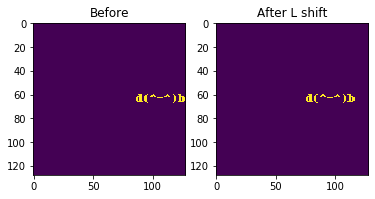

In [0]:
# set up a test case
test_image = trivial_image((128,128), 'd(^-^)b','L',show=True)
print("The pixel movement of the test case is {} to the {}.".format(test_image[2], 
                                                                    test_image[1]))
test = np.reshape(test_image[0], (-1,2,128,128,1))

# outputs probability of class in the order below
# down, left, right, up
model.predict(test)

In [0]:
model_vis = Model(inputs=model.inputs, outputs=model.layers[0].output)
model_vis.summary()
feature_maps = model_vis.predict(test)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 2, 128, 128, 1)]  0         
_________________________________________________________________
Conv1 (Conv3D)               (None, 2, 64, 64, 8)      80        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


In [0]:
plt.rcParams['figure.figsize'] = 20, 10

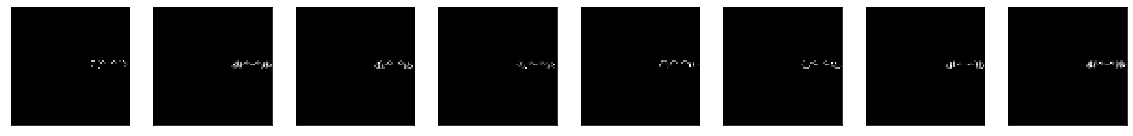

In [0]:
# TODO make bigger plots
# plot all 8 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
  # specify subplot and turn of axis
  ax = plt.subplot(1, square, ix)
  ax.set_xticks([])
  ax.set_yticks([])
  # plot filter channel in grayscale
  plt.imshow(feature_maps[0, 0, :, :, ix-1], cmap='gray', aspect="equal")
  ix += 1
# show the figure
plt.show()